## Explore subreddit data for relevant subreddits

Count mentiones of states over time and examine mentions relative to a state's population.

## Setup
We need an available Java installation to run pyspark. The easiest way to do this is to install JDK and set the proper paths using conda

In [1]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.5.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Utilize S3 Data within local PySpark
* By specifying the `hadoop-aws` jar in our Spark config we're able to access S3 datasets using the s3a file prefix. 
* Since we've already authenticated ourself to SageMaker Studio , we can use our assumed SageMaker ExecutionRole for any S3 reads/writes by setting the credential provider as `ContainerCredentialsProvider`

In [2]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ffe2449b-cdb2-4ae4-89e5-cd55a22a165d;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 430ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------

3.5.0


## Load filtered reddit data

In [3]:
import sagemaker
from sagemaker.spark.processing import PySparkProcessor
session = sagemaker.Session()
bucket = session.default_bucket()

# Load comments data
s3_path_1 = f"s3a://{bucket}/project/comments_filt"
print(f"reading comments from {s3_path_1}")
comments = spark.read.parquet(s3_path_1, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")
comments.printSchema()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-562201516459/project/comments_filt


24/11/11 15:54:41 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 17,667,099x17
root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [4]:
# Display data
comments.show(5)

+--------------------+----------------------+--------------------+--------------------+----------------+-----------+-------------+------+------+-------+----------+----------+------------+-----+--------+-------------+------------+
|              author|author_flair_css_class|   author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded|     id|   link_id| parent_id|retrieved_on|score|stickied|    subreddit|subreddit_id|
+--------------------+----------------------+--------------------+--------------------+----------------+-----------+-------------+------+------+-------+----------+----------+------------+-----+--------+-------------+------------+
|        spicyprepper|                  NULL|                NULL|Another radio cal...|               0| 1698281838|         NULL|  NULL|     0|k6h54i4|t3_17gilus|t3_17gilus|  1698281854|    1|   false|        Maine|    t5_2qts0|
|   tehmightyengineer|            usernormal|I'm givin' 'er al...|Almost certain

In [55]:
# Load submissions data
s3_path_1 = f"s3a://{bucket}/project/submissions_filt"
print(f"reading submissions from {s3_path_1}")
submissions = spark.read.parquet(s3_path_1, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")
submissions.printSchema()

reading submissions from s3a://sagemaker-us-east-1-562201516459/project/submissions_filt


shape of the submissions dataframe is 697,043x21
root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- id: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- quarantine: boolean (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)



In [6]:
# Display data
submissions.show(5)

+-------------------+----------------------+-----------------+-----------+-------------+------------+------+-------+-------+------+------------+-------+----------+------------+-----+--------------------+--------+-----------+------------+--------------------+--------------------+
|             author|author_flair_css_class|author_flair_text|created_utc|distinguished|      domain|edited|     id|is_self|locked|num_comments|over_18|quarantine|retrieved_on|score|            selftext|stickied|  subreddit|subreddit_id|               title|                 url|
+-------------------+----------------------+-----------------+-----------+-------------+------------+------+-------+-------+------+------------+-------+----------+------------+-----+--------------------+--------+-----------+------------+--------------------+--------------------+
|         stlredbird|                  NULL|             NULL| 1720530000|         NULL|   i.redd.it|  NULL|1dz1slo|  false|  true|        2025|  false|     fal

In [7]:
# Convert the UTC timestamp to a date
from pyspark.sql.functions import to_date, from_unixtime
from pyspark.sql.types import DateType
submissions = submissions.withColumn('date', from_unixtime('created_utc').cast(DateType()))
submissions.show(2)

comments = comments .withColumn('date', from_unixtime('created_utc').cast(DateType()))
comments.show(2)

+----------+----------------------+-----------------+-----------+-------------+------------+------+-------+-------+------+------------+-------+----------+------------+-----+---------+--------+---------+------------+--------------------+--------------------+----------+
|    author|author_flair_css_class|author_flair_text|created_utc|distinguished|      domain|edited|     id|is_self|locked|num_comments|over_18|quarantine|retrieved_on|score| selftext|stickied|subreddit|subreddit_id|               title|                 url|      date|
+----------+----------------------+-----------------+-----------+-------------+------------+------+-------+-------+------+------------+-------+----------+------------+-----+---------+--------+---------+------------+--------------------+--------------------+----------+
|stlredbird|                  NULL|             NULL| 1720530000|         NULL|   i.redd.it|  NULL|1dz1slo|  false|  true|        2025|  false|     false|  1720530017| 6411|         |   false| 

In [8]:
# Convert text columns to all lowercase to search
from pyspark.sql.functions import lower

submissions = submissions.withColumn("title_lower", lower('title'))
submissions.show(2)
comments = comments.withColumn("body_lower", lower('body'))
comments.show(2)

+----------+----------------------+-----------------+-----------+-------------+------------+------+-------+-------+------+------------+-------+----------+------------+-----+---------+--------+---------+------------+--------------------+--------------------+----------+--------------------+
|    author|author_flair_css_class|author_flair_text|created_utc|distinguished|      domain|edited|     id|is_self|locked|num_comments|over_18|quarantine|retrieved_on|score| selftext|stickied|subreddit|subreddit_id|               title|                 url|      date|         title_lower|
+----------+----------------------+-----------------+-----------+-------------+------------+------+-------+-------+------+------------+-------+----------+------------+-----+---------+--------+---------+------------+--------------------+--------------------+----------+--------------------+
|stlredbird|                  NULL|             NULL| 1720530000|         NULL|   i.redd.it|  NULL|1dz1slo|  false|  true|        

In [18]:
# Search for mentions of states in test
from pyspark.sql.functions import split, regexp_extract, regexp_extract_all, lit
states = "alabama,alaska,arizona,arkansas,california,colorado,connecticut,delaware,florida,georgia,hawaii,idaho,illinois,indiana,iowa,kansas,kentucky,louisiana,maine,maryland,massachusetts,michigan,minnesota,mississippi,missouri,montana,nebraska,nevada,new hampshire,new jersey,new mexico,new york,north carolina,north dakota,ohio,oklahoma,oregon,pennsylvania,rhode island,south carolina,south dakota,tennessee,texas,utah,vermont,virginia,washington,west virginia,wisconsin,wyoming"
state_list = states.split(",")
print(state_list)

# Find list of words and list them
submissions = submissions.withColumn('states_mentioned', regexp_extract_all('title_lower', lit('(?=^|\s)(' + '|'.join(state_list) + ')(?=\s|$)')))
comments = comments.withColumn('states_mentioned', regexp_extract_all('body_lower', lit('(?=^|\s)(' + '|'.join(state_list) + ')(?=\s|$)')))

['alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina', 'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming']


In [19]:
# Check that regex worked
submissions.groupBy("states_mentioned").count().show(100)
comments.groupBy("states_mentioned").count().show(100)

# Create dummy variable for states mentioned
submissions = submissions.withColumn("mentioned", when(submissions.states_mentioned != [], 1).otherwise(0))
comments = comments.withColumn("mentioned", when(comments.states_mentioned != [], 1).otherwise(0))

+----------------+------+
|states_mentioned| count|
+----------------+------+
| [west virginia]|   159|
| [new hampshire]|   253|
|       [alabama]|   485|
|      [new york]|   464|
|[north carolina]|   343|
|  [pennsylvania]|   355|
|        [alaska]|   375|
|       [montana]|   220|
|  [south dakota]|   122|
|[south carolina]|   170|
|    [new jersey]|   395|
|              []|670446|
|  [north dakota]|    94|
|         [texas]|  2261|
|          [iowa]|   663|
|      [maryland]|   752|
|    [new mexico]|   195|
| [massachusetts]|   385|
|  [rhode island]|   152|
|      [oklahoma]|   513|
|        [oregon]|   881|
|          [utah]|   515|
|   [mississippi]|   258|
|        [nevada]|   165|
|      [arkansas]|   479|
|     [tennessee]|   292|
|         [idaho]|   343|
|       [arizona]|   488|
|      [illinois]|   537|
|       [florida]|  2327|
|     [louisiana]|   375|
|      [nebraska]|   198|
|    [washington]|   345|
|      [delaware]|   249|
|      [michigan]|   956|
|      [virg

+----------------+--------+
|states_mentioned|   count|
+----------------+--------+
| [west virginia]|     603|
| [new hampshire]|     852|
|       [alabama]|    1571|
|      [new york]|    2248|
|[north carolina]|     880|
|  [pennsylvania]|    1009|
|        [alaska]|    1830|
|       [montana]|     872|
|  [south dakota]|     353|
|[south carolina]|     674|
|    [new jersey]|     921|
|              []|17564714|
|  [north dakota]|     293|
|         [texas]|   12258|
|          [iowa]|    2700|
|      [maryland]|    1952|
|    [new mexico]|     898|
| [massachusetts]|    1547|
|  [rhode island]|     593|
|      [oklahoma]|    1442|
|        [oregon]|    2593|
|          [utah]|    2217|
|   [mississippi]|    1212|
|        [nevada]|     468|
|      [arkansas]|    1320|
|     [tennessee]|     908|
|         [idaho]|    2361|
|       [arizona]|    1403|
|      [illinois]|    1453|
|       [florida]|    9883|
|     [louisiana]|    1562|
|      [nebraska]|     784|
|    [washington]|  

In [23]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- body_lower: string (nullable = true)
 |-- states_mentioned: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [44]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd

comments = comments.withColumn("states_mentioned_str", col("states_mentioned").cast("string"))

comments_filt = comments.filter(comments.states_mentioned_str != '[]')
    
grouped_mentions = comments_filt.groupBy("date", "states_mentioned_str").count()

print(type(grouped_mentions))
# Group the data by continent and calculate the average life expectancy for each year
grouped_mentions_df = grouped_mentions.toPandas()



<class 'pyspark.sql.dataframe.DataFrame'>


         date states_mentioned_str  count
0  2024-01-25      [new hampshire]      2
1  2024-03-06             [oregon]      8
2  2024-07-04           [nebraska]      7
3  2024-05-26      [massachusetts]      8
4  2023-08-04              [idaho]      2


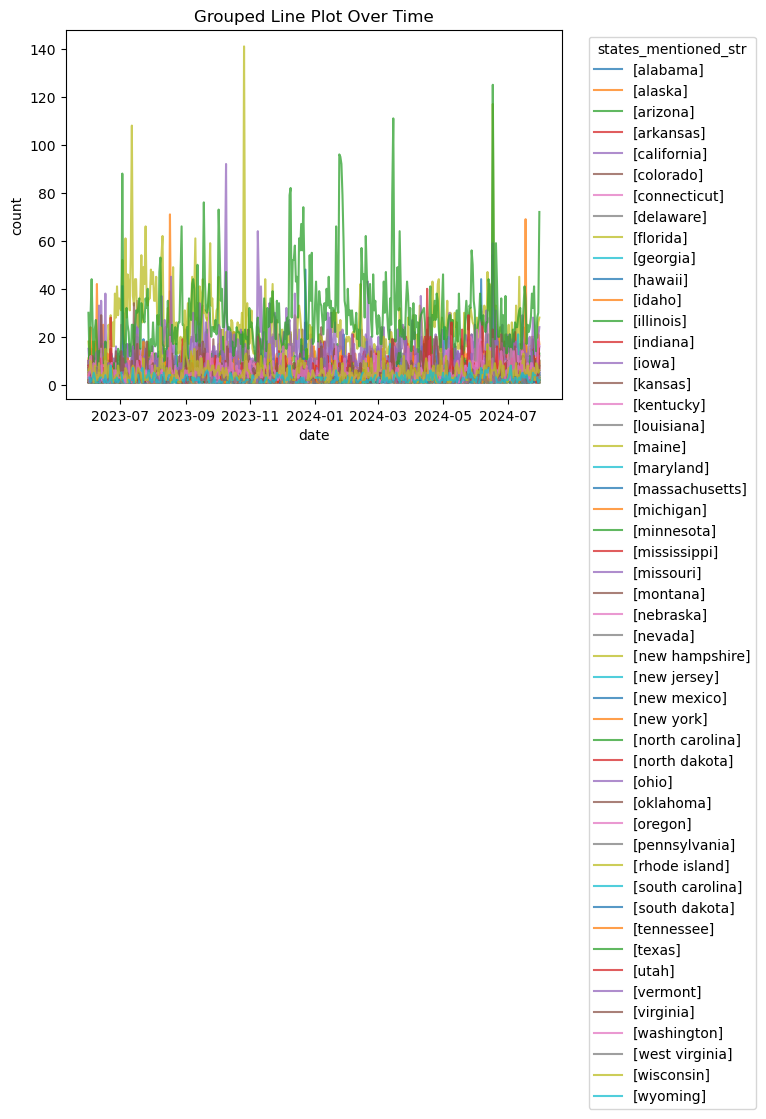

In [52]:
print(grouped_mentions_df.head(5))
#df_state = grouped_mentions_df.groupby(['states_mentioned_str'])

# Create a pivot table to group the data
df_pivot = grouped_mentions_df.pivot(index='date', columns='states_mentioned_str', values='count')

# Plot the data
df_pivot.plot(kind='line', alpha = 0.75)
plt.title('Grouped Line Plot Over Time')
plt.xlabel('date')
plt.ylabel('count')
plt.legend(title='states_mentioned_str', bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

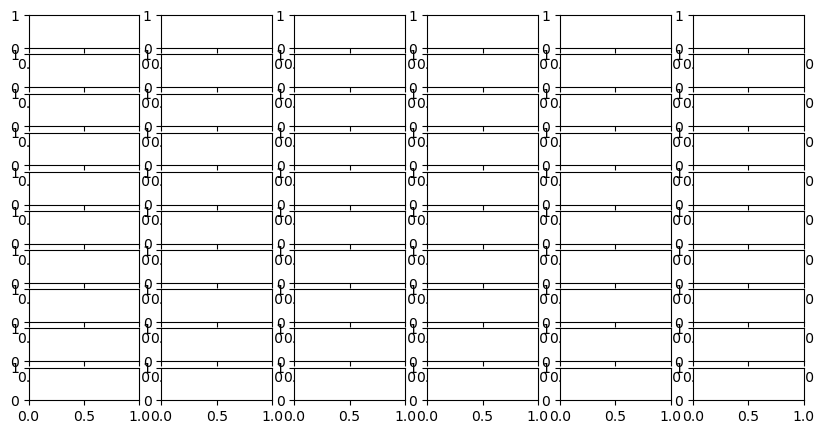

In [54]:
# Create subplots
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(10, 5))

# Plot data in each pane
for group in enumerate(grouped_mentions_df['states_mentioned_str'].unique()):
    group_data = grouped_mentions_df[grouped_mentions_df['states_mentioned_str'] == group]
    axes.plot(group_data['date'], group_data['count'], label='count')
    axes.set_title(f'Group {group}')
    axes.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Create a figure and axis object using the object-oriented approach
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each group as a separate line
for key, group in df_state:
    ax.plot(group['date'], group['count'], label=key)

# Set axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Number of Mentions by State')

# Add a legend
ax.legend()

# Display the grid
ax.grid(True)

# Show the plot
plt.show()